# Diversity Evolutionary Algorithm

In [1]:
import ast
import sqlite3
from functools import partial

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# from examples.z_ec_course.A3_template import NUM_OF_MODULES
import networkx as nx
import numpy as np
import pandas as pd
import umap
from rich.console import Console
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfTransformer

from ariel.body_phenotypes.robogen_lite.decoders.hi_prob_decoding import (
    HighProbabilityDecoder,
)
from ariel.ec.a004 import (
    EA,
    EASettings,
    EAStep,
    Individual,
    Population,
    parent_selection,
)
from ariel.ec.genotypes.nde.nde import NeuralDevelopmentalEncoding
from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
# from ariel_experiments.characterize.individual import analyze_neighbourhood
# from ariel_experiments.characterize.population import (
    # get_full_analyzed_population,
    # matrix_derive_neighbourhood,
    # matrix_derive_neighbourhood_cross_pop,
# )
from ariel_experiments.gui_vis.view_mujoco import view

console = Console()
SEED = 42
RNG = np.random.default_rng(SEED)

# Settings

In [2]:
# Global var
global_fitness_history = []
# global_novelty_history = []

# EA settings
config = EASettings()
config.is_maximisation = False
config.num_of_generations = 30
config.target_population_size = 1000

# evaluation settings
SIM_CONFIG = ctk.SimilarityConfig()
SIM_CONFIG.max_tree_radius = 4
RADIUS = 4

NUM_OF_MODULES = 20
GENOTYPE_SIZE = 64

# Helper functions for EA

In [3]:
##################################
def record_mean_fitness(population: Population) -> Population:
    mean_fitness = np.mean([ind.fitness for ind in population if ind.alive])
    global_fitness_history.append(mean_fitness)
    return population

# EA functions

In [4]:
def float_creep(
    individual: list[list[float]] | list[list[list[float]]],
    mutation_probability: float,
) -> list[list[float]]:
    # Prep
    ind_arr = np.array(individual)
    shape = ind_arr.shape

    # Generate mutation values
    mutator = RNG.uniform(
        size=shape,
    )

    # Include negative mutations
    sub_mask = RNG.choice(
        [-1, 1],
        size=shape,
    )

    # Determine which positions to mutate
    do_mask = RNG.choice(
        [1, 0],
        size=shape,
        p=[mutation_probability, 1 - mutation_probability],
    )
    mutation_mask = mutator * sub_mask * do_mask
    new_genotype = ind_arr + mutation_mask
    return new_genotype.tolist()


def make_random_robot(genotype_size: int = 64) -> Individual:
    """
    Produces an robot with only its genotype.

    genotype_size is standard 64
    """
    ind = Individual()
    ind.genotype = [
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
    ]
    nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
    hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

    matrixes = nde.forward(np.array(ind.genotype))
    ind.tags["graph"] = ctk.to_string(ctk.from_graph(hpd.probability_matrices_to_graph(
        matrixes[0], matrixes[1], matrixes[2],
    )))
    ind.fitness = 0.0
    return ind


def crossover(population: Population) -> Population:
    """Does uniform crossover."""
    mask = RNG.random(size=np.array(population[0].genotype).shape) < 0.5
    children = []
    for parent in population:
        child = Individual()
        parent2 = RNG.choice(population)
        child.genotype = np.where(
            mask, np.array(parent.genotype), np.array(parent2.genotype),
        ).tolist()
        children.append(child)
    population.extend(children)
    return population


def mutation(population: Population) -> Population:
    """Randomly changes genotype values by a random amount."""
    mutation_rate = 0.01  # mutation rate to be changed
    for ind in population:
        if ind.tags.get("mut", False):
            genes = ind.genotype
            mutated = [
                float_creep(
                    individual=genes[0],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[1],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[2],
                    mutation_probability=mutation_rate,
                ),
            ]
            ind.genotype = mutated
            ind.requires_eval = True

    for ind in population:
        if ind.requires_eval:
            nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
            hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

            matrixes = nde.forward(np.array(ind.genotype))
            ind_graph = hpd.probability_matrices_to_graph(
                matrixes[0], matrixes[1], matrixes[2],
            )
            ind.tags["ctk_string"] = ctk.to_string(ctk.from_graph(ind_graph))

    return population


# def evaluation_diversity(population: Population) -> Population:
#     """Produces an individual that is evaluated."""
#     graph_population = [None] * len(population)

#     # for initial population creation
#     if len(population) <= 1:
#         population[0].fitness = 0.0
#         population[0].requires_eval = True
#         return population

#     for idx, ind in enumerate(population):

#         graph_population[idx] = ctk.to_graph(ctk.from_string(ind.tags["graph"]))


#     analyzed_population = get_full_analyzed_population(
#         graph_population,
#         analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
#         derivers=[],
#         n_jobs=-1,
#         hide_tracker=True,
#     )
#     matrix_result = matrix_derive_neighbourhood(
#         analyzed_population.raw,
#         config=similarity_config,
#         symmetric=True,
#         n_jobs=-1,
#         hide_tracker=True,
#     )
#     matrix = matrix_result["similarity_matrix"]["full"]

#     for index, ind in enumerate(population):
#         if ind.requires_eval:
#             ind.requires_eval = False  # diversity gets evaluated each time

#             fitness = np.sum(matrix[index])
#             population[index].fitness = (float(fitness) - 1) / len(population)

#     return population

def apply_tfidf_transformer(count_matrix):
    transformer = TfidfTransformer()
    return transformer.fit_transform(count_matrix)


def apply_umap_n2(count_matrix):
    return umap.UMAP(init="random", random_state=42, transform_seed=42, n_jobs=1, metric="cosine", n_neighbors=2).fit_transform(
        count_matrix,
    )


def apply_emb_to_dist(umap_emb_matrix):
    condensed_distances = pdist(umap_emb_matrix, metric="euclidean")
    return squareform(condensed_distances)


def apply_collapse_to_fitness(matrix):
    return matrix.sum(axis=1) - matrix.diagonal()


def get_cumsum_dict(matrix_dict):
    sorted_radii = sorted(matrix_dict.keys())
    cum_dict = {}
    running_sum = None

    for r in sorted_radii:
        current_matrix = matrix_dict[r]

        if running_sum is None:
            running_sum = current_matrix
        else:
            running_sum += current_matrix
        cum_dict[r] = running_sum

    return cum_dict


def evaluate_diversity_tfidf_umap(population: Population) -> Population:
    subtrees = [ctk.collect_tree_hash_config_mode(ctk.from_nde_genotype(individual.genotype_), config=SIM_CONFIG) for individual in population]
    count_matrix_dict = ctk.get_count_matrix(subtrees, config=SIM_CONFIG)

    tfidf_matrix_dict = ctk.matrix_dict_applier(count_matrix_dict, apply_tfidf_transformer)
    tfidf_umap_dict_n2 = ctk.matrix_dict_applier(tfidf_matrix_dict, apply_umap_n2)
    tfidf_umapdist_matrix_dict_n2 = ctk.matrix_dict_applier(tfidf_umap_dict_n2, apply_emb_to_dist)
    cumsum_dict = get_cumsum_dict(tfidf_umapdist_matrix_dict_n2)
    fitness_dict = ctk.matrix_dict_applier(cumsum_dict, apply_collapse_to_fitness)

    for idx, individual in enumerate(population):
        individual.fitness = fitness_dict[SIM_CONFIG.max_tree_radius][idx]

    return population


def evaluate_diversity_umap(population: Population) -> Population:
    subtrees = [ctk.collect_tree_hash_config_mode(ctk.from_nde_genotype(individual.genotype_), config=SIM_CONFIG) for individual in population]
    count_matrix_dict = ctk.get_count_matrix(subtrees, config=SIM_CONFIG)

    umap_dict_n2 = ctk.matrix_dict_applier(count_matrix_dict, apply_umap_n2)
    umapdist_matrix_dict_n2 = ctk.matrix_dict_applier(umap_dict_n2, apply_emb_to_dist)
    cumsum_dict = get_cumsum_dict(umapdist_matrix_dict_n2)
    fitness_dict = ctk.matrix_dict_applier(cumsum_dict, apply_collapse_to_fitness)

    for idx, individual in enumerate(population):
        individual.fitness = fitness_dict[SIM_CONFIG.max_tree_radius][idx]

    return population


def evaluate_diversity_cum_cos(population: Population) -> Population:
    subtrees = [ctk.collect_tree_hash_config_mode(ctk.from_nde_genotype(individual.genotype_), config=SIM_CONFIG) for individual in population]
    count_matrix_dict = ctk.get_count_matrix(subtrees, config=SIM_CONFIG)
    
    cos_count_matrix_dict = ctk.matrix_dict_applier(count_matrix_dict, cosine_similarity)
    cumsum_dict = get_cumsum_dict(cos_count_matrix_dict)
    fitness_dict = ctk.matrix_dict_applier(cumsum_dict, apply_collapse_to_fitness)

    for idx, individual in enumerate(population):
        individual.fitness = fitness_dict[SIM_CONFIG.max_tree_radius][idx]

    return population


def survivor_selection(population: Population) -> Population:

    RNG.shuffle(population)
    current_pop_size = len(population)

    for idx in range(0, len(population) - 1, 2):
        ind_i = population[idx]
        ind_j = population[idx + 1]

        if config.is_maximisation:
            if ind_i.fitness < ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        elif ind_i.fitness > ind_j.fitness:
            ind_i.alive = False
        else:
            ind_j.alive = False
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break

    return population


# run


In [5]:
population_list = [
    make_random_robot(GENOTYPE_SIZE) for _ in range(config.target_population_size)
]

In [6]:
ops = [
    EAStep("parent_selection", parent_selection),
    EAStep("crossover", crossover),
    EAStep("mutation", mutation),
    EAStep("evaluation", evaluate_diversity_cum_cos),
    EAStep("survivor_selection", survivor_selection),
    EAStep("record_fitness", record_mean_fitness),
]

In [7]:
ea = EA(
    population_list,
    operations=ops,
    num_of_generations=config.num_of_generations,
)

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

In [8]:
ea.run()

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

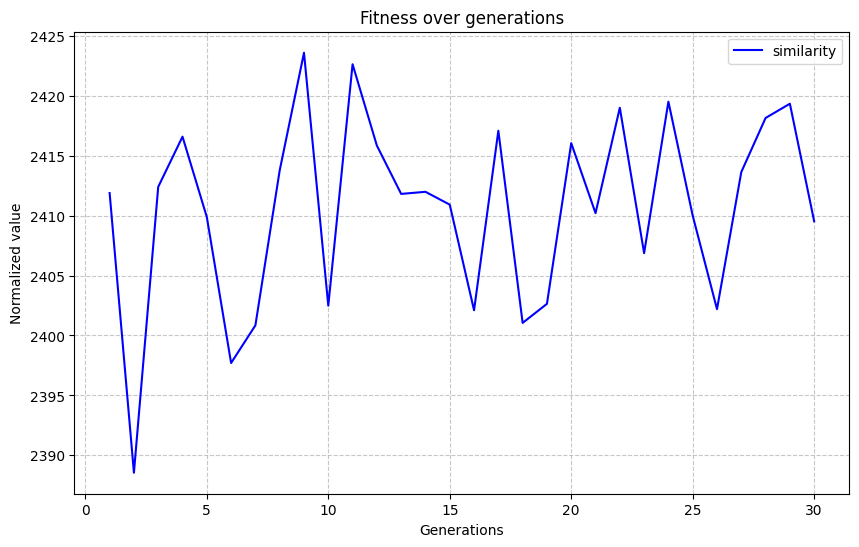

In [9]:
def plot_fitness_history() -> None:
    if not global_fitness_history:
        return

    generations = range(1, len(global_fitness_history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(
        generations,
        global_fitness_history,
        # marker="o",
        linestyle="-",
        color="blue",
        label="similarity",
    )

    plt.legend(loc="upper right")
    plt.title("Fitness over generations")
    plt.xlabel("Generations")
    plt.ylabel("Normalized value")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


plot_fitness_history()